In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split as split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_score, recall_score, f1_score, classification_report

#EDA and Data Preprocessing

In [2]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/MH.csv')
data

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,Risk
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk
...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,high risk
1010,55,120,90,18.0,98.0,60,high risk
1011,35,85,60,19.0,98.0,86,high risk
1012,43,120,90,18.0,98.0,70,high risk


In [3]:
data_proc = data.replace({'high risk': 2, 'mid risk': 1, 'low risk' : 0}, regex=True)

<ipython-input-3-15f2912322e4>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_proc = data.replace({'high risk': 2, 'mid risk': 1, 'low risk' : 0}, regex=True)


## Remove Impossible Data

In [4]:
data_proc = data_proc[~((data_proc["BodyTemp"] > 100) & (data_proc["Risk"] == 0))]
data_proc = data_proc[~((data_proc["BS"] > 10) & (data_proc["Risk"] == 0) | (data_proc["BS"] > 10) & (data_proc["Risk"] == 1))]
data_proc = data_proc[~((data_proc["Age"] > 50) & (data_proc["Risk"] == 0) | (data_proc["Age"] > 50) & (data_proc["Risk"] == 1))]
data_proc = data_proc[~(data_proc["HeartRate"] < 55)]
data_proc

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,Risk
0,25,130,80,15.0,98.0,86,2
1,35,140,90,13.0,98.0,70,2
2,29,90,70,8.0,100.0,80,2
3,30,140,85,7.0,98.0,70,2
4,35,120,60,6.1,98.0,76,0
...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,2
1010,55,120,90,18.0,98.0,60,2
1011,35,85,60,19.0,98.0,86,2
1012,43,120,90,18.0,98.0,70,2


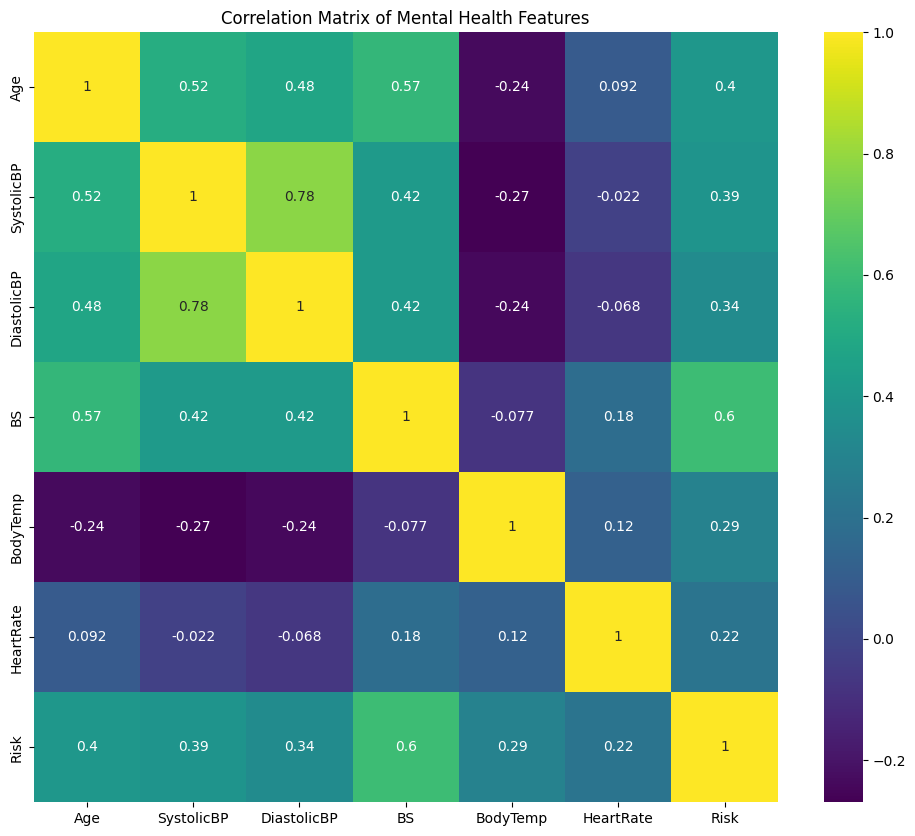

In [5]:
plt.figure(figsize=(12, 10))
sns.heatmap(data_proc.corr(), annot=True, cmap='viridis')
plt.title('Correlation Matrix of Mental Health Features')
plt.show()


## Remove Outliers

In [6]:
from scipy import stats


z_scores = np.abs(stats.zscore(data_proc))
threshold = 3

keep_rows = (z_scores < threshold).all(axis=1)

data_proc = data_proc[keep_rows]

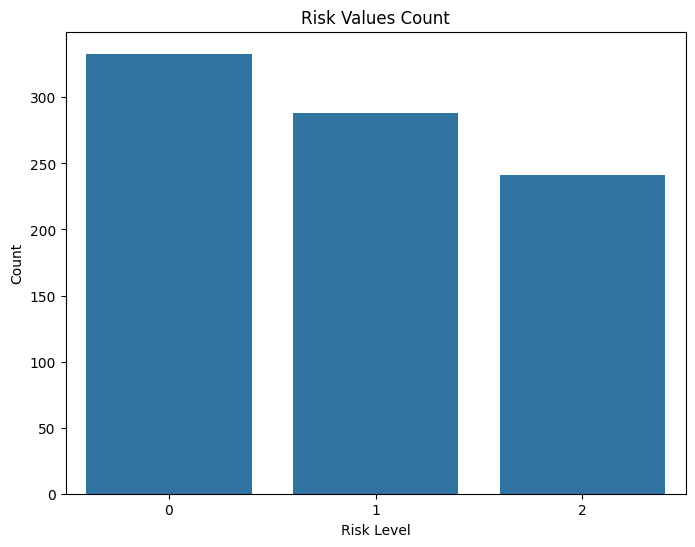

In [7]:
risk_counts = data_proc['Risk'].value_counts()


plt.figure(figsize=(8, 6))
sns.barplot(x=risk_counts.index, y=risk_counts.values)
plt.title('Risk Values Count')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.show()

In [8]:
from sklearn.model_selection import train_test_split


X_proc = data_proc.drop("Risk", axis=1)
y_proc = data_proc["Risk"]

x_train_proc, x_test_proc, y_train_proc, y_test_proc = train_test_split(
    X_proc, y_proc, train_size=0.8, test_size=0.2, random_state=1
)


print(f"Processed data has {x_train_proc.shape[0]} train samples and {x_test_proc.shape[0]} test samples")

Processed data has 689 train samples and 173 test samples


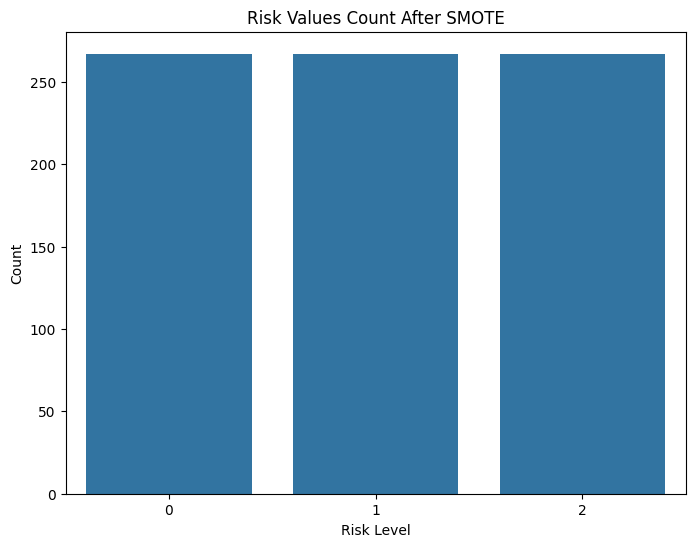

In [9]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=1)
x_train_smote, y_train_smote = smote.fit_resample(x_train_proc, y_train_proc)


risk_counts_smote = pd.Series(y_train_smote).value_counts()


plt.figure(figsize=(8, 6))
sns.barplot(x=risk_counts_smote.index, y=risk_counts_smote.values)
plt.title('Risk Values Count After SMOTE')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.show()


In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(x_train_smote, y_train_smote)
dt_pred = dt_model.predict(x_test_proc)
print("Decision Tree Accuracy:", accuracy_score(y_test_proc, dt_pred))
print(classification_report(y_test_proc, dt_pred))

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(x_train_smote, y_train_smote)
rf_pred = rf_model.predict(x_test_proc)
print("Random Forest Accuracy:", accuracy_score(y_test_proc, rf_pred))
print(classification_report(y_test_proc, rf_pred))

# XGBoost
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(x_train_smote, y_train_smote)
xgb_pred = xgb_model.predict(x_test_proc)
print("XGBoost Accuracy:", accuracy_score(y_test_proc, xgb_pred))
print(classification_report(y_test_proc, xgb_pred))


Decision Tree Accuracy: 0.884393063583815
              precision    recall  f1-score   support

           0       0.92      0.86      0.89        66
           1       0.80      0.93      0.86        57
           2       0.96      0.86      0.91        50

    accuracy                           0.88       173
   macro avg       0.89      0.88      0.89       173
weighted avg       0.89      0.88      0.89       173

Random Forest Accuracy: 0.8959537572254336
              precision    recall  f1-score   support

           0       0.93      0.86      0.90        66
           1       0.82      0.93      0.87        57
           2       0.96      0.90      0.93        50

    accuracy                           0.90       173
   macro avg       0.90      0.90      0.90       173
weighted avg       0.90      0.90      0.90       173

XGBoost Accuracy: 0.8728323699421965
              precision    recall  f1-score   support

           0       0.93      0.86      0.90        66
       

##Random Forest

### Gridsearch

In [11]:
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500, 1000],
    'max_depth': [10, 20, 5, None, 50, 100],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)


grid_search.fit(x_train_smote, y_train_smote)


print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy Score:", grid_search.best_score_)


best_rf_model = grid_search.best_estimator_

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
Best Accuracy Score: 0.8589440993788819


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Accuracy Score: 0.855194099378882

## Confusion Matrix

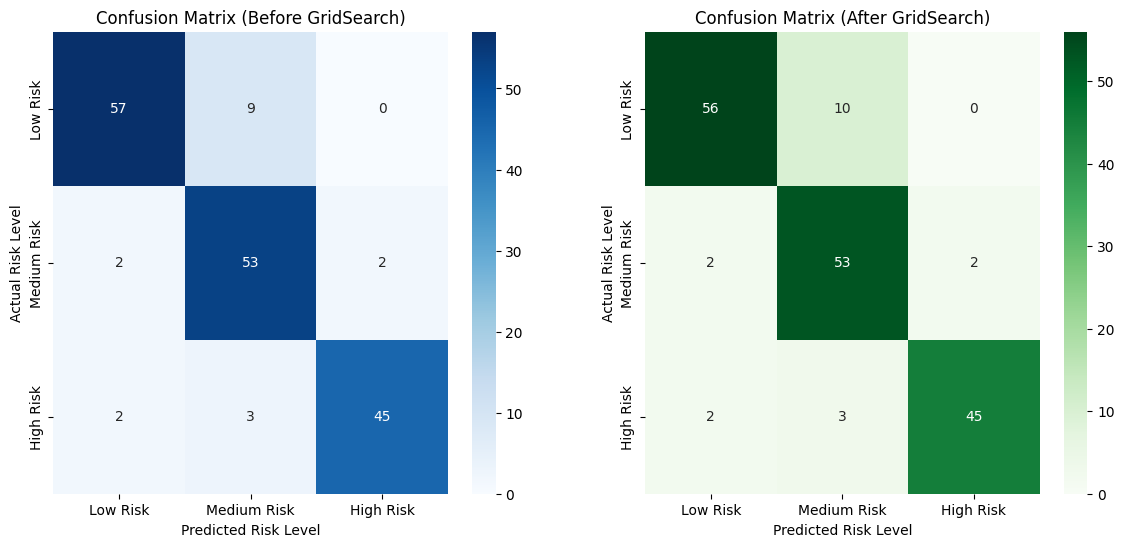

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


rf_pred = rf_model.predict(x_test_proc)
grid_pred = best_rf_model.predict(x_test_proc)

import seaborn as sns
import matplotlib.pyplot as plt

risk_labels = ["Low Risk", "Medium Risk", "High Risk"]

baseline_cm = confusion_matrix(y_test_proc, rf_pred)
optimized_cm = confusion_matrix(y_test_proc, grid_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(baseline_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=risk_labels, yticklabels=risk_labels, ax=axes[0])
axes[0].set_title("Confusion Matrix (Before GridSearch)")
axes[0].set_xlabel("Predicted Risk Level")
axes[0].set_ylabel("Actual Risk Level")


sns.heatmap(optimized_cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=risk_labels, yticklabels=risk_labels, ax=axes[1])
axes[1].set_title("Confusion Matrix (After GridSearch)")
axes[1].set_xlabel("Predicted Risk Level")
axes[1].set_ylabel("Actual Risk Level")

plt.show()



## Base Model vs GridSearchCV

In [17]:
print(" Base Random Forest")
print(classification_report(y_test_proc, rf_pred))

print("\n GridSearchCV Random Forest")
print(classification_report(y_test_proc, grid_pred))

 Base Random Forest
              precision    recall  f1-score   support

           0       0.93      0.86      0.90        66
           1       0.82      0.93      0.87        57
           2       0.96      0.90      0.93        50

    accuracy                           0.90       173
   macro avg       0.90      0.90      0.90       173
weighted avg       0.90      0.90      0.90       173


 GridSearchCV Random Forest
              precision    recall  f1-score   support

           0       0.93      0.85      0.89        66
           1       0.80      0.93      0.86        57
           2       0.96      0.90      0.93        50

    accuracy                           0.89       173
   macro avg       0.90      0.89      0.89       173
weighted avg       0.90      0.89      0.89       173

